## RandomForest 
Scaling version 1 from 02_feature_engineering
used dummies for pure categoricals, kept numericals and scaled them using StandardScaler.

#### First Exploration
Try a random forest and see how it performs!

In [18]:
#initial imports 
import sys
import pandas as pd
import numpy as np
from pathlib import Path
from typing import Optional
import seaborn as sns
import matplotlib.pyplot as plt

import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Get the absolute path of the current file/notebook
# If using Jupyter, use Path.cwd(). If using a .py script, use Path(__file__).parent
curr_dir = Path.cwd()

# Calculate the project root (adjust '.parent' count as needed)
# If your notebook is in 'project/notebooks/', the root is 1 level up
project_root = curr_dir.parent.parent 

# Add project root to system path so Python can find 'utils'
sys.path.append(str(project_root))

print(f"Project Root added to path: {project_root}")

from utils.feature_engineer_df import build_features 

#for the scaling and encoding 
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
#cleanup 

pd.set_option('display.max_columns', None)

Project Root added to path: /Users/surya/Documents/neue_fische/11_project/ds-ml-project_kickstarters


In [19]:
#get your data from our utils
build_features(
    input_path=Path.cwd().resolve().parents[1] / "data" / "cleaned" / "kickstarter_cleaned.csv",
    output_path=Path.cwd().resolve().parents[1] / "data" / "feature" / "kickstarter_featured.csv",
    raw_path=Path.cwd().resolve().parents[1] / "data" / "raw" / "ks-projects-201801.csv",
    logger=logger
)

# Load Files as DataFrames
BASE_DIR = Path.cwd().resolve().parents[1]
data_file = BASE_DIR / "data" / "feature" / "kickstarter_featured.csv"

filepath = Path(data_file)

df = pd.read_csv(filepath, encoding='latin-1', low_memory=False)

INFO:__main__:Starting feature engineering pipeline
INFO:__main__:Loaded 331675 rows
INFO:__main__:Final columns before save: ['id', 'main_category', 'deadline', 'launched', 'backers', 'country', 'usd_pledged_real', 'usd_goal_real', 'duration_days', 'target', 'main_category_grouped', 'continent', 'launched_year', 'launched_month', 'deadline_year', 'deadline_month', 'usd_goal_bins', 'usd_pledged_bins', 'pledged_per_category', 'goal_per_category', 'category_goal_percentile', 'duration_bins', 'backers_per_pledged', 'backer_pledged_bins', 'launch_season', 'deadline_season']
INFO:__main__:Saved engineered dataset to /Users/surya/Documents/neue_fische/11_project/ds-ml-project_kickstarters/data/feature/kickstarter_featured.csv


In [20]:
#list of columns to "hard drop" from feature engineering dataframe
columns_to_drop = ['id', #irrelevant
                   'main_category', #substituted in a satisfactory way
                   'deadline', 'launched', #created new categories 
                   'backers', 'usd_pledged_real', 'usd_pledged_bins', 'backers_per_pledged', 'backer_pledged_bins', 'pledged_per_category', #everything to do with "future information"
                   'launched_year', 'deadline_year', #info about the past and not seasonal
                   ]
# drop them
dfc = df.drop(columns=columns_to_drop)

Get dummies for pure categoricals:

In [21]:
#season launched, dropping first as it's multicollinear
df_sl = pd.get_dummies(df['launch_season'], prefix = 'sl_', drop_first=True, dtype=int)

#season deadline, dropping first
df_sd = pd.get_dummies(df['deadline_season'], prefix = 'sd_', drop_first=True, dtype=int)

#main category_grouped, dropping first
df_cat = pd.get_dummies(df['main_category_grouped'], prefix = 'cat_', drop_first=True, dtype=int)

#continent, dropping first
df_co = pd.get_dummies(df['continent'], prefix = 'co_', drop_first=True, dtype=int)

#put everything back together again: 
dff = pd.concat([dfc, df_sl, df_sd, df_cat, df_co], axis=1)


In [22]:
#let's soft-drop everything we just encoded
#commented out all the keepers 
columns_to_softdrop = ['country', #we kept it for comparison
                       # 'usd_goal_real', #right now I want to try scaling actual values 
                       #'duration_days', #I want to scale these and drop the bins instead for now 
                       # 'target', (obviously)
                       'main_category_grouped', 'continent', #after creating dummies, get rid of these!
                        'launched_month', 'deadline_month', #because we have season but might want to look closer
                        'usd_goal_bins', #using category_goal_percentile (those two are redundant)
                        #'goal_per_category', #it's a polynomial feature - not independent but that's probably ok
                       'category_goal_percentile', #it's an orinal bin so keeping 'goal per category' instead
                       'duration_bins', #want to use actual values instead, using duration_days
                       'launch_season', 'deadline_season', #gotten dummies 
                       #'duration_bins_coded', #dropped the whole encoding code 
                       ]
# keeping the already dummied ones obviously 

In [23]:
df_to_scale = dff.drop(columns=columns_to_softdrop, axis=1)
display(df_to_scale.columns)

Index(['usd_goal_real', 'duration_days', 'target', 'goal_per_category',
       'sl__Spring', 'sl__Summer', 'sl__Winter', 'sd__Spring', 'sd__Summer',
       'sd__Winter', 'cat__Creative', 'cat__Entertainment', 'cat__Other',
       'cat__Tech', 'co__Europe', 'co__North America', 'co__Oceania'],
      dtype='object')

Scale the remaining numerical columns 

In [24]:
#first, create our dfs 
X = df_to_scale.drop(columns=['target'])
y = df_to_scale['target']
#get train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, stratify = y)
print("Df before", df_to_scale.shape)
print("X_train shape", X_train.shape)
print("X_test shape", X_test.shape)
print("y_train shape", y_train.shape)
print("y_test shape", y_test.shape)

Df before (293019, 17)
X_train shape (205113, 16)
X_test shape (87906, 16)
y_train shape (205113,)
y_test shape (87906,)


In [25]:
#get the columns to standardise 
col_scale = ['usd_goal_real',
             'duration_days',
             'goal_per_category',
             ]

#instantiate
scaler = StandardScaler()
#scale 
X_train_scaled = scaler.fit_transform(X_train[col_scale])
X_test_scaled = scaler.fit_transform(X_test[col_scale])
#make it a df again
X_train_scaled = pd.DataFrame(
    X_train_scaled,
    columns=col_scale,
    index=X_train.index
)

X_test_scaled = pd.DataFrame(
    X_test_scaled,
    columns=col_scale,
    index=X_test.index
)

In [26]:
#drop the original axes again
X_train = X_train.drop(col_scale, axis=1)
X_test = X_test.drop(col_scale, axis=1)
#and check if everything's still in order 
X_train.index.equals(X_train_scaled.index)
X_test.index.equals(X_test_scaled.index)

True

In [27]:
# put it back together again 
X_train_sp = pd.concat([X_train_scaled, X_train ], axis=1)
X_test_sp = pd.concat([X_test_scaled, X_test], axis=1)
#and check
print("Dff shape", dff.shape)
print("X_train shape", X_train_scaled.shape)
print("X_test shape", X_test_scaled.shape)
print("X_train shape after scaling", X_train_sp.shape)
print("X_test shape after scaling", X_test_sp.shape)
print("train split head:")
display(X_train_sp.head())
print("test split head:")
display(X_test_sp.head())

Dff shape (293019, 27)
X_train shape (205113, 3)
X_test shape (87906, 3)
X_train shape after scaling (205113, 16)
X_test shape after scaling (87906, 16)
train split head:


,usd_goal_real,duration_days,goal_per_category,sl__Spring,sl__Summer,sl__Winter,sd__Spring,sd__Summer,sd__Winter,cat__Creative,cat__Entertainment,cat__Other,cat__Tech,co__Europe,co__North America,co__Oceania
57281,-0.006214,-0.310206,-0.844947,0,0,0,0,0,0,1,0,0,0,0,1,0
264757,0.020483,0.885107,-0.192760,0,1,0,0,0,0,0,0,0,0,0,1,0
28338,-0.032193,-0.947706,1.452947,0,1,0,0,1,0,0,0,1,0,0,1,0
150240,-0.037251,1.363232,-0.844947,0,0,1,0,0,1,1,0,0,0,0,1,0
291618,-0.028165,-0.310206,0.983668,0,0,0,0,0,0,0,1,0,0,0,1,0


test split head:


,usd_goal_real,duration_days,goal_per_category,sl__Spring,sl__Summer,sl__Winter,sd__Spring,sd__Summer,sd__Winter,cat__Creative,cat__Entertainment,cat__Other,cat__Tech,co__Europe,co__North America,co__Oceania
74198,-0.030944,2.095838,0.988030,0,1,0,0,1,0,0,1,0,0,0,1,0
57285,-0.019671,2.095838,0.988030,0,0,0,0,0,1,0,1,0,0,1,0,0
94280,-0.033632,-0.309181,-1.039898,0,1,0,0,1,0,1,0,0,0,0,1,0
169955,-0.036054,-0.309181,-1.067390,0,1,0,0,1,0,1,0,0,0,0,0,1
224769,-0.028533,-0.309181,0.154996,0,0,0,0,0,0,0,1,0,0,1,0,0


### Get a baseline first

<Axes: >

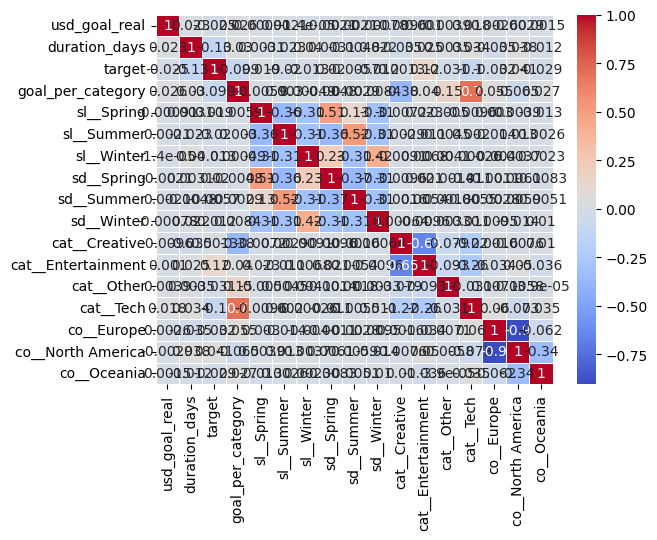

In [35]:
corr = df_to_scale.corr()
sns.heatmap(data=corr, annot=True, linewidth=0.5, cmap='coolwarm')

## Random Forest 
using the train-test-split: 
* X_train_sp
* X_test_sp
* y_train
* y_test

In [36]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, confusion_matrix

In [17]:
#get features for feature importance 
features = list(X_train_sp.columns)
#create a model
model = RandomForestClassifier(n_estimators = 50, #start low
                               random_state = 42, #just any
                               max_features=8, #manually set it to 1/2 dataset 
                               n_jobs=-1, #use whole CPU
                               )
#fit the model
model.fit(X_train_sp, y_train)

RandomForestClassifier(max_features=8, n_estimators=50, n_jobs=-1,
                       random_state=42)

In [29]:
#first description of the model 
n_nodes = []
max_depths = []
#create stats 
for tree in model.estimators_:
  n_nodes.append(tree.tree_.node_count) #ask the tree how many nodes it has
  max_depths.append(tree.tree_.max_depth)
#get averages  
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of nodes 90617
Average maximum depth 39


In [32]:
#check the original
train_predictions = model.predict(X_train_sp)
train_probabilites = model.predict_proba(X_train_sp)[:, 1] #get the positives
#check with test: 
test_predictions = model.predict(X_test_sp)
test_probabilities = model.predict_proba(X_test_sp)[:, 1]

print(f'Train ROC AUC Score: {roc_auc_score(y_train, train_probabilites)}')
print(f'Test ROC AUC Score: {roc_auc_score(y_test, test_probabilities)}')
print(f"Baseline ROC AUC calling everyone successful: {roc_auc_score(y_test, [1 for _ in range(len(y_test))])}")

Train ROC AUC Score: 0.9344639720579019
Test ROC AUC Score: 0.6197402656005501
Baseline ROC AUC calling everyone successful: 0.5


In [33]:
matrix = confusion_matrix(y_test, test_predictions)
print(matrix)

[[31815 15904]
 [20256 19931]]


In [34]:
fi_model = pd.DataFrame({'feature': features,
                         'importance': model.feature_importances_}).sort_values('importance', ascending=False)
fi_model.head()

,feature,importance
0,usd_goal_real,0.526737
1,duration_days,0.217509
2,goal_per_category,0.080255
7,sd__Summer,0.021900
8,sd__Winter,0.020508


### one shot at optimization

In [39]:
#hyperparameter grid 
param_grid = {
    'n_estimators': [10, 20, 40, 50, 70, 90, 120], #just because I can, fibonacci-style guess
    'max_depth': [None] + list(np.arange(3, 21).astype(int)),
    'max_features': ['auto', 'sqrt', None, 8], 
    'max_leaf_nodes': [20, 100, 1000, 3000, 8000, 20000, 60000, 100000],
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True, False]
}

#get an instance to use for random search:
estimator = RandomForestClassifier(random_state = 42)
#create random search model 
rs = RandomizedSearchCV(estimator,
                        param_grid, 
                        n_jobs = -1,
                        scoring = 'roc_auc',
                        cv = 5,
                        n_iter = 10,
                        verbose = 4, 
                        random_state = 42)

# fit it 
rs.fit(X_train_sp, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/surya/Documents/neue_fische/11_project/ds-ml-project_kickstarters/.venv/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/surya/Documents/neue_fische/11_project/ds-ml-project_kickstarters/.venv/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/surya/Documents/neue_fische/11_project/ds-ml-project_kickstarters/.venv/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_fea

[CV 1/5] END bootstrap=False, max_depth=18, max_features=auto, max_leaf_nodes=60000, min_samples_split=5, n_estimators=20;, score=0.677 total time=   6.5s
[CV 5/5] END bootstrap=False, max_depth=18, max_features=auto, max_leaf_nodes=60000, min_samples_split=5, n_estimators=20;, score=0.679 total time=   6.5s
[CV 3/5] END bootstrap=False, max_depth=18, max_features=auto, max_leaf_nodes=60000, min_samples_split=5, n_estimators=20;, score=0.680 total time=   6.5s
[CV 4/5] END bootstrap=False, max_depth=18, max_features=auto, max_leaf_nodes=60000, min_samples_split=5, n_estimators=20;, score=0.677 total time=   6.8s
[CV 2/5] END bootstrap=False, max_depth=18, max_features=auto, max_leaf_nodes=60000, min_samples_split=5, n_estimators=20;, score=0.683 total time=   6.9s
[CV 3/5] END bootstrap=True, max_depth=3, max_features=sqrt, max_leaf_nodes=20, min_samples_split=10, n_estimators=120;, score=0.667 total time=   5.9s
[CV 1/5] END bootstrap=True, max_depth=3, max_features=sqrt, max_leaf_nod

/Users/surya/Documents/neue_fische/11_project/ds-ml-project_kickstarters/.venv/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END bootstrap=True, max_depth=10, max_features=auto, max_leaf_nodes=20, min_samples_split=10, n_estimators=10;, score=0.682 total time=   0.8s


/Users/surya/Documents/neue_fische/11_project/ds-ml-project_kickstarters/.venv/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END bootstrap=True, max_depth=10, max_features=auto, max_leaf_nodes=20, min_samples_split=10, n_estimators=10;, score=0.687 total time=   1.0s


/Users/surya/Documents/neue_fische/11_project/ds-ml-project_kickstarters/.venv/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END bootstrap=False, max_depth=6, max_features=None, max_leaf_nodes=20, min_samples_split=2, n_estimators=50;, score=0.672 total time=  15.7s
[CV 2/5] END bootstrap=False, max_depth=6, max_features=None, max_leaf_nodes=20, min_samples_split=2, n_estimators=50;, score=0.678 total time=  15.7s


/Users/surya/Documents/neue_fische/11_project/ds-ml-project_kickstarters/.venv/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/surya/Documents/neue_fische/11_project/ds-ml-project_kickstarters/.venv/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END bootstrap=True, max_depth=10, max_features=auto, max_leaf_nodes=20, min_samples_split=10, n_estimators=10;, score=0.681 total time=   0.9s
[CV 3/5] END bootstrap=False, max_depth=6, max_features=None, max_leaf_nodes=20, min_samples_split=2, n_estimators=50;, score=0.673 total time=  16.0s


/Users/surya/Documents/neue_fische/11_project/ds-ml-project_kickstarters/.venv/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/surya/Documents/neue_fische/11_project/ds-ml-project_kickstarters/.venv/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END bootstrap=True, max_depth=10, max_features=auto, max_leaf_nodes=20, min_samples_split=10, n_estimators=10;, score=0.685 total time=   0.8s
[CV 5/5] END bootstrap=True, max_depth=10, max_features=auto, max_leaf_nodes=20, min_samples_split=10, n_estimators=10;, score=0.687 total time=   0.8s


/Users/surya/Documents/neue_fische/11_project/ds-ml-project_kickstarters/.venv/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/surya/Documents/neue_fische/11_project/ds-ml-project_kickstarters/.venv/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END bootstrap=True, max_depth=3, max_features=sqrt, max_leaf_nodes=20, min_samples_split=10, n_estimators=120;, score=0.670 total time=   6.1s
[CV 5/5] END bootstrap=True, max_depth=3, max_features=sqrt, max_leaf_nodes=20, min_samples_split=10, n_estimators=120;, score=0.673 total time=   6.2s


/Users/surya/Documents/neue_fische/11_project/ds-ml-project_kickstarters/.venv/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END bootstrap=False, max_depth=15, max_features=auto, max_leaf_nodes=3000, min_samples_split=5, n_estimators=20;, score=0.703 total time=   4.0s
[CV 1/5] END bootstrap=False, max_depth=15, max_features=auto, max_leaf_nodes=3000, min_samples_split=5, n_estimators=20;, score=0.700 total time=   4.5s
[CV 3/5] END bootstrap=False, max_depth=15, max_features=auto, max_leaf_nodes=3000, min_samples_split=5, n_estimators=20;, score=0.700 total time=   4.1s
[CV 4/5] END bootstrap=False, max_depth=15, max_features=auto, max_leaf_nodes=3000, min_samples_split=5, n_estimators=20;, score=0.700 total time=   4.0s
[CV 4/5] END bootstrap=False, max_depth=6, max_features=None, max_leaf_nodes=20, min_samples_split=2, n_estimators=50;, score=0.675 total time=  14.8s
[CV 5/5] END bootstrap=False, max_depth=6, max_features=None, max_leaf_nodes=20, min_samples_split=2, n_estimators=50;, score=0.677 total time=  14.8s
[CV 2/5] END bootstrap=True, max_depth=18, max_features=8, max_leaf_nodes=100, min

/Users/surya/Documents/neue_fische/11_project/ds-ml-project_kickstarters/.venv/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END bootstrap=True, max_depth=11, max_features=sqrt, max_leaf_nodes=1000, min_samples_split=5, n_estimators=10;, score=0.699 total time=   1.4s
[CV 5/5] END bootstrap=True, max_depth=11, max_features=sqrt, max_leaf_nodes=1000, min_samples_split=5, n_estimators=10;, score=0.701 total time=   1.5s


/Users/surya/Documents/neue_fische/11_project/ds-ml-project_kickstarters/.venv/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/surya/Documents/neue_fische/11_project/ds-ml-project_kickstarters/.venv/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END bootstrap=False, max_depth=8, max_features=auto, max_leaf_nodes=1000, min_samples_split=5, n_estimators=20;, score=0.691 total time=   2.8s


/Users/surya/Documents/neue_fische/11_project/ds-ml-project_kickstarters/.venv/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END bootstrap=False, max_depth=8, max_features=auto, max_leaf_nodes=1000, min_samples_split=5, n_estimators=20;, score=0.690 total time=   2.6s
[CV 2/5] END bootstrap=False, max_depth=8, max_features=auto, max_leaf_nodes=1000, min_samples_split=5, n_estimators=20;, score=0.696 total time=   2.8s


/Users/surya/Documents/neue_fische/11_project/ds-ml-project_kickstarters/.venv/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END bootstrap=False, max_depth=8, max_features=auto, max_leaf_nodes=1000, min_samples_split=5, n_estimators=20;, score=0.694 total time=   2.9s
[CV 5/5] END bootstrap=False, max_depth=8, max_features=auto, max_leaf_nodes=1000, min_samples_split=5, n_estimators=20;, score=0.694 total time=   3.1s
[CV 1/5] END bootstrap=False, max_depth=15, max_features=8, max_leaf_nodes=20000, min_samples_split=2, n_estimators=90;, score=0.696 total time=  28.9s
[CV 2/5] END bootstrap=False, max_depth=15, max_features=8, max_leaf_nodes=20000, min_samples_split=2, n_estimators=90;, score=0.699 total time=  28.3s
[CV 4/5] END bootstrap=False, max_depth=15, max_features=8, max_leaf_nodes=20000, min_samples_split=2, n_estimators=90;, score=0.696 total time=  28.1s
[CV 3/5] END bootstrap=False, max_depth=15, max_features=8, max_leaf_nodes=20000, min_samples_split=2, n_estimators=90;, score=0.698 total time=  28.6s
[CV 5/5] END bootstrap=False, max_depth=15, max_features=8, max_leaf_nodes=20000, min_

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14, 15,
                                                      16, 17, 18, 19, 20],
                                        'max_features': ['auto', 'sqrt', None,
                                                         8],
                                        'max_leaf_nodes': [20, 100, 1000, 3000,
                                                           8000, 20000, 60000,
                                                           100000],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [10, 20, 40, 50, 70, 90,
                                                         120]},
                   random_state=42, scoring='roc_auc', verbose=4)

In [41]:
rs.best_params_

{'n_estimators': 20,
 'min_samples_split': 10,
 'max_leaf_nodes': 100,
 'max_features': 8,
 'max_depth': 19,
 'bootstrap': True}

### go for best model

In [44]:
best_model = rs.best_estimator_

In [45]:
best_train_predictions = best_model.predict(X_train_sp)
best_train_probas = best_model.predict_proba(X_train_sp)[:, 1]
#and again 
best_test_predictions = best_model.predict(X_test_sp)
best_test_probas = best_model.predict_proba(X_test_sp)[:, 1]

In [46]:
#now after optimization
b_n_nodes = []
b_max_depths = []

for tree in best_model.estimators_:
    b_n_nodes.append(tree.tree_.node_count)
    b_max_depths.append(tree.tree_.max_depth)

print(f'Average number of nodes {int(np.mean(b_n_nodes))}')
print(f'Average maximum depth {int(np.mean(b_max_depths))}')    

Average number of nodes 199
Average maximum depth 12


In [48]:
new_cm = confusion_matrix(y_test, best_test_predictions)
print(matrix)

[[31815 15904]
 [20256 19931]]


In [49]:
print(f'Train ROC AUC Score: {roc_auc_score(y_train, best_train_probas)}')
print(f'Test ROC AUC Score: {roc_auc_score(y_test, best_test_probas)}')
print(f"Baseline ROC AUC calling everyone successful: {roc_auc_score(y_test, [1 for _ in range(len(y_test))])}")

Train ROC AUC Score: 0.7050986554975087
Test ROC AUC Score: 0.6967549518716112
Baseline ROC AUC calling everyone successful: 0.5


In [50]:
fi_model = pd.DataFrame({'feature': features,
                         'importance': best_model.feature_importances_}).sort_values('importance', ascending=False)
fi_model.head()

,feature,importance
0,usd_goal_real,0.511556
1,duration_days,0.216760
2,goal_per_category,0.111991
10,cat__Entertainment,0.109202
9,cat__Creative,0.034641
